## Prepare the envirement and required packages
#### Preparing the envirnment
```sh
cd PROJECT_PATH
conda create -n mat2vec python=3.6 -y
conda activate mat2vec
# To activate it for the Jupyter Notebook
conda install -c anaconda ipykernel -y
pip install jupyterlab
python -m ipykernel install --user --name=mat2vec
```

#### [Installing the word embedding model for materials science](https://github.com/materialsintelligence/mat2vec)
```sh
# https://github.com/materialsintelligence/mat2vec
git clone git@github.com:materialsintelligence/mat2vec.git
pip install --ignore-installed -r mat2vec/requirements.txt
cd mat2vec
python setup.py install
cd ..
```
#### [Installing Chem Data Extractor](http://chemdataextractor.org/docs/install)
```sh
# http://chemdataextractor.org/docs/install
# Installing the Toolkit
conda config --add channels conda-forge
conda install chemdataextractor -y
# Getting the Data Files
cde data download
conda update chemdataextractor
```

#### Other requirnments
```
pip install ase pandas tqdm
pip install Levenshtein

```

#### Run this notebook under the mat2vec envirnment
On the top right under the "Logout" button, "mat2vec" has to be displayed. If not so, go to the kernel menue and change the kernel to "mat2vec"

In [2]:
from utility.utility_general import *
from IPython.display import display
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_rows', 200)

In [180]:
# Example one
from mat2vec.processing import MaterialsTextProcessor
text_processor = MaterialsTextProcessor()
text_processor.process("LiCoO2 is a battery cathode material.") 

(['CoLiO2', 'is', 'a', 'battery', 'cathode', 'material', '.'],
 [('LiCoO2', 'CoLiO2')])

In [181]:
# Example two
from gensim.models import Word2Vec
w2v_model = Word2Vec.load("mat2vec/mat2vec/training/models/pretrained_embeddings")
w2v_model.wv.most_similar("thermoelectric")

[('thermoelectrics', 0.8435686826705933),
 ('thermoelectric_properties', 0.8339033126831055),
 ('thermoelectric_power_generation', 0.7931368947029114),
 ('thermoelectric_figure_of_merit', 0.791649341583252),
 ('seebeck_coefficient', 0.7753845453262329),
 ('thermoelectric_generators', 0.7641353011131287),
 ('figure_of_merit_ZT', 0.7587920427322388),
 ('thermoelectricity', 0.7515754699707031),
 ('Bi2Te3', 0.7480161190032959),
 ('thermoelectric_modules', 0.7434878945350647)]

In [182]:
# Example three
text_processor = MaterialsTextProcessor()
w2v_model.wv.most_similar(
    positive=["cubic", text_processor.normalized_formula("CdSe")], 
    negative=[text_processor.normalized_formula("GaAs")], topn=1)

[('hexagonal', 0.6162797212600708)]

## Listing all the chemical compositions in the materials science literature

### Initializing

In [18]:
from gensim.models import Word2Vec
from mat2vec.processing import MaterialsTextProcessor
# from util import *
# import util, imp
# imp.reload(util)
from utility.utility_general import *
from IPython.display import display
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_rows', 200)
from datetime import datetime
from joblib import Parallel, delayed
from tqdm import tqdm
from ase.formula import Formula

# from anomaly_generation_tools import generate_anomaly_structures
import anomaly_generation_tools, imp
from ase.io import write as write_atoms
from ase.io import read as read_atoms
imp.reload(anomaly_generation_tools)
pass

### Listing all the words and compositions

In [3]:
text_processor = MaterialsTextProcessor()
w2v_model = Word2Vec.load("mat2vec/mat2vec/training/models/pretrained_embeddings")

In [9]:
words = list(w2v_model.wv.vocab.keys())
counts = [i.count for i in list(w2v_model.wv.vocab.values())]
words = pd.DataFrame({'words': words, 'literature counts':counts})
words

,words,literature counts
0,structural,154091
1,features,42347
2,of,11756393
3,crystalline,72626
4,anodic_alumina,411
...,...,...
529681,cim(x),5
529682,EuMnO,1
529683,Al10LuO30Y9,1
529684,C14H18O7,1


### Most repeated compositions in the literature

In [10]:
print('Different chemical compositions and the number of repeats in the literature.')
from ase.formula import Formula

def is_simple_chemical_formula(x):
    try:
        Formula(x)
        return text_processor.is_simple_formula(x)
    except:
        return False
filter_compositions = lambda x: is_simple_chemical_formula(x['words'])
compositions = words[words.apply(filter_compositions, axis=1)]
compositions = compositions.rename(columns={'words': 'formulas'})
compositions = compositions.sort_values('literature counts', ascending=False)
compositions = compositions.reset_index(drop=True)
compositions['formula hill'] = [Formula(i).format('hill') for i in compositions['formulas']]
assert np.unique(compositions['formulas']).shape[0] == len(compositions)
compositions

Different chemical compositions and the number of repeats in the literature.


,formulas,literature counts,formula hill
0,O2Ti,173915,O2Ti
1,OZn,130445,OZn
2,CO2,99530,CO2
3,O2Si,81220,O2Si
4,Al2O3,66705,Al2O3
...,...,...,...
108308,Ga472Mn509Ni1019,1,Ga472Mn509Ni1019
108309,Fe17Ga17Mn33Ni33,1,Fe17Ga17Mn33Ni33
108310,Al84Ni9Y7,1,Al84Ni9Y7
108311,AgMn3N,1,AgMn3N


### Most repeated compositions in the COD
#### Based on the SQL 
This is the old way. Now I do it based on the CIF file after removing the duplicate structures.

In [62]:
print('Different chemical compositions and the number of repeats in the COD database.')

cod_formula = run_query_on_cod('select formula from data')
cod_formula.rename(columns={'formula': 'formulas'}, inplace=True)
cod_formula['formulas'] = cod_formula['formulas'].apply(lambda s: ''.join(s.split())[1:-1])
f, c = np.unique(cod_formula['formulas'], return_counts=True)
cod_formula = pd.DataFrame({'formulas': f, 'cod counts': c}).sort_values('cod counts', ascending=False)
cod_formula.reset_index(inplace=True, drop=True)
cod_formula.head(15)

Different chemical compositions and the number of repeats in the COD database.


,formulas,cod counts
0,,513
1,O2Si,300
2,MgO,208
3,Al2MgO4,191
4,MgO3Si,178
5,Fe,150
6,Fe2MgO4,123
7,C8N4S3,120
8,CCaO3,105
9,C21H17Cl2NO2,101


#### Based on the CIF files

In [11]:
cod = load_var(f'{local_data_path}/data_banks/cod/df.pkl')
from ase.formula import Formula
cod['Formula'] = [Formula(i).reduce()[0].format('hill') for i in cod['formula']]
f, c = np.unique(cod['Formula'], return_counts=True)
ind = np.flip(np.argsort(c))
(f[ind], c[ind])
cod_df = pd.DataFrame({
    'formula hill': f[ind],
    'cod counts': c[ind]
})
cod_df

,formula hill,cod counts
0,O2Si,88
1,C,25
2,AlO4P,25
3,C8H9NO2,17
4,CH,16
...,...,...
250723,C39H54Cl2CoN10O11,1
250724,C39H54CdMo12N6O62P8Zn2,1
250725,C39H54BrCoN10O3,1
250726,C39H54Br4Cl2N4Ni2,1


### Combining the literature and cod repetition numbers

In [22]:
# compositions_plus_cod = pd.merge(compositions, cod_formula, how='left', on='formulas')
compositions_plus_cod = pd.merge(compositions, cod_df, how='left', on='formula hill')
assert (compositions_plus_cod['formulas'] == compositions['formulas']).all()
compositions_plus_cod.fillna(0, inplace=True)
compositions_plus_cod['cod counts'] = pd.Series(np.array(compositions_plus_cod['cod counts'], dtype='int'))
del compositions_plus_cod['formula hill']

### Removing abbreviations mistakenly taken into account as compositions

In [23]:
ind = compositions_plus_cod['formulas'].isin(pd.Series([
    'CNTs',
    'SWCNTs',
    'SWNTs',
]))
compositions_plus_cod = compositions_plus_cod[~ind].reset_index(drop=True)

os.makedirs(local_data_path + 'data_bases/cspd', exist_ok=True)
compositions_plus_cod.to_csv(local_data_path + '/data_bases/cspd/literature.csv', index=False)
compositions_plus_cod#.head(200)

,formulas,literature counts,cod counts
0,O2Ti,173915,10
1,OZn,130445,4
2,CO2,99530,7
3,O2Si,81220,88
4,Al2O3,66705,4
...,...,...,...
108305,Ga472Mn509Ni1019,1,0
108306,Fe17Ga17Mn33Ni33,1,0
108307,Al84Ni9Y7,1,0
108308,AgMn3N,1,1


## Plotting mostly repeated compositions

Text(0.5, 1.0, 'Top 20 compositions')

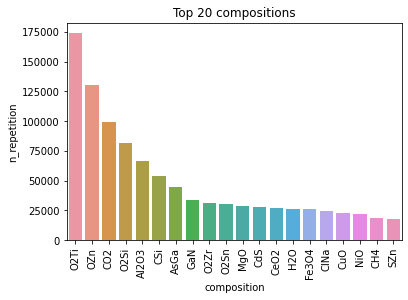

In [24]:
import seaborn as sns 
import matplotlib.pyplot as plt

# compositions_plus_cod = pd.read_csv('results/data_preparation/formula no filter.txt', sep='\t', index_col=0)
compositions_plus_cod = pd.read_csv(local_data_path + '/data_bases/cspd/literature.csv')
compositions_plus_cod['composition'] = [i.strip() for i in compositions_plus_cod['formulas']]
compositions_plus_cod['rank'] = np.array(range(len(compositions_plus_cod)), dtype=int) + 1
compositions_plus_cod['n_repetition'] = compositions_plus_cod['literature counts']
sns.barplot(data=compositions_plus_cod.head(20), x='composition', y='n_repetition')
plt.xticks(rotation=90)
plt.title('Top 20 compositions')

In [25]:
percentiles= np.array([.25, .5, .8, .85, .9, .95, .99, .995, .998, .999])
top_n = np.array((1 - percentiles) * len(compositions_plus_cod), dtype=int)
# print(f'Selecting top {top_n} compositions in the literature')
top_n_df = pd.DataFrame({'percentiles %': percentiles*100, 'top_n formulas': top_n})
display(top_n_df)
compositions_plus_cod_summary = compositions_plus_cod.describe(percentiles=percentiles)
# for i in range(len(percentiles)):
#     compositions_plus_cod_summary.loc[f'{percentiles[i]*100}%', 'number of compositions'] = top_n[i]
compositions_plus_cod_summary

,percentiles %,top_n formulas
0,25.0,81232
1,50.0,54155
2,80.0,21661
3,85.0,16246
4,90.0,10830
5,95.0,5415
6,99.0,1083
7,99.5,541
8,99.8,216
9,99.9,108


,literature counts,cod counts,rank,n_repetition
count,108310.000000,108310.000000,108310.000000,108310.000000
mean,27.070206,0.160198,54155.500000,27.070206
std,904.795643,0.668161,31266.548165,904.795643
min,1.000000,0.000000,1.000000,1.000000
25%,1.000000,0.000000,27078.250000,1.000000
50%,2.000000,0.000000,54155.500000,2.000000
80%,5.000000,0.000000,86648.200000,5.000000
85%,7.000000,0.000000,92063.650000,7.000000
90%,11.000000,1.000000,97479.100000,11.000000
95%,27.000000,1.000000,102894.550000,27.000000


In [26]:
# List of selected anomaly compositions

# anomaly_compositions = pd.read_csv('results/data_preparation/formula no filter.txt', sep='\t', index_col=0)
anomaly_compositions = pd.read_csv(local_data_path + '/data_bases/cspd/literature.csv')
# top_n = int((1 - .999) * len(anomaly_compositions))
top_n = 300

anomaly_compositions = anomaly_compositions[:top_n]
print(f'Selecting top {top_n} compositions in the literature')
with pd.option_context('display.max_rows', 300):
    display(anomaly_compositions)

Selecting top 300 compositions in the literature


,formulas,literature counts,cod counts
0,O2Ti,173915,10
1,OZn,130445,4
2,CO2,99530,7
3,O2Si,81220,88
4,Al2O3,66705,4
5,CSi,54034,6
6,AsGa,44805,1
7,GaN,33945,2
8,O2Zr,30851,5
9,O2Sn,30535,2


## Extracting the crystal structures corresponding to the selected compositions

### [Preparing the Atomic Structure Generator](https://github.com/adavari871/AtomicStructureGenerator)

~~~sh
git clone git@github.com:adavari871/AtomicStructureGenerator.git
pip install ase==3.21.1
sudo apt-get install rar unrar
cd AtomicStructureGenerator/
unrar x -e CSPD.part1.rar
cd ..
~~~

In [7]:
# Example one

from AtomicStructureGenerator.cspd import atomic_structure_generator


structure_list = atomic_structure_generator(
    symbols='TiO2',
    # lw=True,
    # format='cif',
    # fu=[1, 4],
    cspd_file='AtomicStructureGenerator/CSPD.db',
    # sgn=[1,225],
    # ndensity=0.071,
    # volume=49.0,
    # mindis=[
    #     [1.85,  1.113],
    #     [1.113, 1.202]],
    # nstr=300,
    # maxatomn=60,
)

Chemical Formula: O16Ti8    Space Group:   33
Chemical Formula: O8Ti4     Space Group:   82
Chemical Formula: O8Ti4     Space Group:   14
Chemical Formula: O8Ti4     Space Group:   62
Chemical Formula: O8Ti4     Space Group:  213
Chemical Formula: O8Ti4     Space Group:  187
Chemical Formula: O8Ti4     Space Group:    1
Chemical Formula: O8Ti4     Space Group:   60
Chemical Formula: O8Ti4     Space Group:   62
Chemical Formula: O16Ti8    Space Group:   61
Chemical Formula: O8Ti4     Space Group:  198
Chemical Formula: O16Ti8    Space Group:   61
Chemical Formula: O16Ti8    Space Group:    9
Chemical Formula: O16Ti8    Space Group:   24
Chemical Formula: O4Ti2     Space Group:   34
Chemical Formula: O8Ti4     Space Group:   26
Chemical Formula: O16Ti8    Space Group:   14
Chemical Formula: O16Ti8    Space Group:   52
Chemical Formula: O12Ti6    Space Group:   12
Chemical Formula: O8Ti4     Space Group:   61
Chemical Formula: O4Ti2     Space Group:  137
Chemical Formula: O4Ti2     Space 

Chemical Formula: O16Ti8    Space Group:   61
Chemical Formula: O8Ti4     Space Group:   74
Chemical Formula: O6Ti3     Space Group:  152
Chemical Formula: O8Ti4     Space Group:   62
Chemical Formula: O4Ti2     Space Group:   14
Chemical Formula: O12Ti6    Space Group:   11
Chemical Formula: O10Ti5    Space Group:  141
Chemical Formula: O8Ti4     Space Group:  111
Chemical Formula: O8Ti4     Space Group:   72
Chemical Formula: O6Ti3     Space Group:  149
Chemical Formula: O6Ti3     Space Group:  166
Chemical Formula: O8Ti4     Space Group:   29
Chemical Formula: O16Ti8    Space Group:   28
Chemical Formula: O8Ti4     Space Group:   15
Chemical Formula: O8Ti4     Space Group:   51
Chemical Formula: O12Ti6    Space Group:  166
Chemical Formula: O4Ti2     Space Group:    4
Chemical Formula: O8Ti4     Space Group:   60
Chemical Formula: O6Ti3     Space Group:  156
Chemical Formula: O16Ti8    Space Group:    9
Chemical Formula: O6Ti3     Space Group:  160
Chemical Formula: O16Ti8    Space 

In [28]:
# A list of available spacegroups in the COD

from utility.utility_crystal import SpaceGroups
import pandas as pd
from IPython.display import display
pd.set_option('display.max_rows', 700)
pd.set_option('display.max_rows', 700)
SpaceGroups().table_cod

,sgn,Hall,Schoenflies,HM,HMu,class,Nau
1,1,P 1,C1^1,P 1,P 1,triclinic,1\n
2,2,-P 1,Ci^1,P -1,P -1,triclinic,2\n
3,3,P 2y,C2^1,P 1 2 1,P 1 2 1,monoclinic,2\n
4,3,P 2,C2^1,P 1 1 2,P 1 1 2,monoclinic,2\n
5,3,P 2x,C2^1,P 2 1 1,P 2 1 1,monoclinic,2\n
6,4,P 2yb,C2^2,P 1 21 1,P 1 21 1,monoclinic,2\n
7,4,P 2c,C2^2,P 1 1 21,P 1 1 21,monoclinic,2\n
8,4,P 2xa,C2^2,P 21 1 1,P 21 1 1,monoclinic,2\n
9,5,C 2y,C2^3,C 1 2 1,C 1 2 1,monoclinic,4\n
10,5,A 2y,C2^3,A 1 2 1,A 1 2 1,monoclinic,4\n


### Searching the CSPD for hypothetical structures

In [30]:
from datetime import datetime
from joblib import Parallel, delayed
from tqdm import tqdm

# from anomaly_generation_tools import generate_anomaly_structures
import anomaly_generation_tools, imp
from ase.io import write as write_atoms
imp.reload(anomaly_generation_tools)

top_n = 300

print('Generating anomoly structures.', flush=True)
# anomaly_compositions = pd.read_csv('results/data_preparation/formula no filter.txt', sep='\t', index_col=0)
anomaly_compositions = pd.read_csv(local_data_path + '/data_bases/cspd/literature.csv')
print('top_n = ', top_n, flush=True)
anomaly_compositions = anomaly_compositions[:top_n]

time_1 = datetime.now()
iterable = anomaly_compositions['formulas'].tolist()

output = Parallel(n_jobs=32)(delayed(anomaly_generation_tools.generate_anomaly_structures)
                             (it, multi_outputs=True) 
                             for _, it in enumerate(tqdm(iterable, leave=False, position=0)))

save_var(output, f'tmp/output_top_n_{top_n}.pkl')
time_2 = datetime.now()
print('Finished: Creating anomalies. Run time:', str(time_2-time_1)[:-7])

Generating anomoly structures.
top_n =  300


Finished: Creating anomalies. Run time: 0:01:56


### Refining the CSPD results
* Removing redundant based on sgn
* Making sure they fit in the resolution of the model (min_dist > 0.5)

In [53]:
top_n = 300
output = load_var(f'tmp/output_top_n_{top_n}.pkl')

In [54]:
import tqdm
import crystals_tools

for i in tqdm.tqdm(range(len(output)), leave=True, position=0):
    output[i]['df'].drop_duplicates(subset=['sgn'], inplace=True)
    output[i]['df']['min dist'] = [crystals_tools.atoms_find_min_dist(a) for a in output[i]['df']['atom']]
    output[i]['df'] = output[i]['df'][output[i]['df']['min dist']>0.5] # Model's resolution
    output[i]['df'].reset_index(drop=True, inplace=True)
    output[i]['df']
save_var(output, f'tmp/output_top_n_{top_n}_refined.pkl')

100%|██████████| 300/300 [00:01<00:00, 165.98it/s]


### Anomaly selection from hypothetical structures

In [55]:
from utility.utility_general import *
top_n = 300

# output = load_var(f'tmp/output_top_n_{top_n}_refined.pkl')
# anomaly_compositions = pd.read_csv('results/data_preparation/formula no filter.txt', sep='\t', index_col=0)[:top_n]
anomaly_compositions = pd.read_csv(local_data_path + '/data_bases/cspd/literature.csv')
anomaly_compositions.rename(columns={'formulas': 'formula', 
                                     'literature counts': 'literature',
#                                      'cod counts': 'cod'
                                    }, inplace=True)

In [56]:
# top_n = 1080

cod_threshold = 1
min_num_anomaly_per_composition = 5
iterable = anomaly_compositions['formula'].tolist()

# cols = ['total cspd', 'total cod', 'total cspd cod']
# for i in range(len(output)):
#     for j in reversed(range(len(output[i]))):
#         if find_min_dist(output[i]['df'].loc[j, 'atom']) < 0.5:
#             print('removed by min distant constraint')
#             output[i]['df'].drop(j, inplace=True)
    
df_anomaly = pd.DataFrame({'formula': iterable})
df_anomaly['total anomaly'] = pd.Series([len(i['df']) for i in output])
df_anomaly.fillna(0, inplace=True)
df_anomaly = df_anomaly.astype({'total anomaly': int})
# df_anomaly['anomaly constrained'] = pd.Series([min(len(i['cod'])*cod_threshold, len(i['df'])) for i in output])
# df_anomaly['anomaly sgn constrained'] = pd.Series([min(len(np.unique(i['cod']['sgn']))*cod_threshold,
#                                                        len(i['df']))
#                                                     for i in output])
# df_anomaly['anomaly selected'] = df_anomaly['anomaly constrained'].apply(\
#                                 lambda x: max(x, min_num_anomaly_per_composition))

df_anomaly = pd.merge(df_anomaly, anomaly_compositions, how='left', on='formula')
df_anomaly['anomaly selected'] = 5
df_anomaly['anomaly selected'] = df_anomaly[['anomaly selected','cod counts']].max(axis=1)
df_anomaly['anomaly selected'] = df_anomaly[['anomaly selected','total anomaly']].min(axis=1)

# for c in cols:
#     df_anomaly[c] = pd.Series([output[j][c] for j in range(len(output))])
# df_anomaly = df_anomaly[:top_n]
# df_anomaly.to_csv(f'{local_data_path}/data_bases/cspd/cif_top_{top_n}_summary.csv')
# n = sum(df_anomaly['total anomaly'])
# print(f'Total generated anomaly (top_n = {top_n}) = {n:,}')
df_anomaly.to_csv(f'{local_data_path}/data_bases/cspd/summary.csv')
# df_anomaly[df_anomaly['anomaly selected']<5]
df_anomaly

,formula,total anomaly,literature,cod counts,anomaly selected
0,O2Ti,79,173915,10,10
1,OZn,67,130445,4,5
2,CO2,80,99530,7,7
3,O2Si,44,81220,88,44
4,Al2O3,38,66705,4,5
...,...,...,...,...,...
108305,Ga472Mn509Ni1019,0,1,0,0
108306,Fe17Ga17Mn33Ni33,0,1,0,0
108307,Al84Ni9Y7,0,1,0,0
108308,AgMn3N,0,1,1,0


In [57]:
df_anomaly.head(300)

,formula,total anomaly,literature,cod counts,anomaly selected
0,O2Ti,79,173915,10,10
1,OZn,67,130445,4,5
2,CO2,80,99530,7,7
3,O2Si,44,81220,88,44
4,Al2O3,38,66705,4,5
...,...,...,...,...,...
295,CoH2O2,71,1041,1,5
296,Si3Ti5,40,1034,1,5
297,BFeNd,41,1030,0,5
298,CuFe2O4,43,1029,0,5


### Summery of anomaly selection

In [61]:
df_anomaly_summary = pd.DataFrame({
    'total anomaly': [df_anomaly['total anomaly'].sum()],
#     'anomaly constrained': [df_anomaly['anomaly constrained'].sum()],
#     'anomaly sgn constrained': [df_anomaly['anomaly sgn constrained'].sum()],
    'anomaly selected': [df_anomaly['anomaly selected'].sum()],
})
df_anomaly_summary

,total anomaly,anomaly selected
0,17368,1546


### A test on Levenshtein distance

In [ ]:
# https://github.com/luozhouyang/python-string-similarity
# https://towardsdatascience.com/calculating-string-similarity-in-python-276e18a7d33a

import Levenshtein
Levenshtein.ratio('hexagonal - 194 - P 63/m m c', 'hexagonal - 194 - Pp 63/m m c')

df = output[1]['df']
from utility import utility_crystal
import imp
imp.reload(utility_crystal)
sg = utility_crystal.SpaceGroups()

df_cod = output[1]['cod']
for c in ['HM', 'class']:
    df_cod[c] = [sg.convert(i, 'sgn', c, pick_one=True) for i in df_cod['sgn']]
df_cod['sg_str'] = df_cod['class'].str.slice(0,3) + ' - ' + df_cod['sgn'].astype(str) + ' - ' + df_cod['HM']

for c in ['HM', 'class']:
    df[c] = [sg.convert(i, 'sgn', c, pick_one=True) for i in df['sgn']]
df['sg_str'] = df['class'].str.slice(0,3) + ' - ' + df['sgn'].astype(str) + ' - ' + df['HM']
df['sg_cod_dist'] = [max([Levenshtein.ratio(i, c) for c in np.unique(df_cod['sg_str'])]) for i in df['sg_str']]
df.sort_values(by=['sg_cod_dist']).drop_duplicates(subset='sgn', keep="first")

### Selecting anomalies based on the Levenshtein distance to the existing COD samples

In [139]:
import Levenshtein, tqdm, warnings, shutil
from ase.io import write as write_atoms
np.random.seed(0)

top_n = 300

# shutil.rmtree(f'{local_data_path}/data_bases/cspd/cif_top_{top_n}/')

print('Saving the generated structures as CIF files')
tot_cspd = []
tot_cod = cod = []
from utility import utility_crystal
import imp
imp.reload(utility_crystal)
sg = utility_crystal.SpaceGroups()

print('top_n = ', top_n, flush=True)

df_all_selected = None
for row_i, formula in tqdm.tqdm(enumerate(iterable[:top_n]), position=0, leave=True):
    df = output[row_i]['df']
    if len(df) == 0:
        continue
    df_cod = output[row_i]['cod']
    path = f'{local_data_path}/data_bases/cspd/cif_top_{top_n}/{row_i:06}_{formula.strip()}/'
#     rel_dir = f'{local_data_path}/data_bases/cspd/cif_top_{top_n}/{row_i:06}_{formula.strip()}/'
    
    os.makedirs(path, exist_ok=True)
    
    # Selection of anomalies based on Levenshtein distant of spacegroups
    for c in ['HM', 'class']:
        df_cod[c] = [sg.convert(i, 'sgn', c, pick_one=True) for i in df_cod['sgn']]
    df_cod['sg_str'] = None
    if len(df_cod) > 0:
        df_cod['sg_str'] = df_cod['class'].str.slice(0,3) + ' - ' + df_cod['sgn'].astype(str)\
                            + ' - ' + df_cod['HM']
    df_cod = df_cod.dropna()

    for c in ['HM', 'class']:
        df[c] = [sg.convert(i, 'sgn', c, pick_one=True) for i in df['sgn']]
    df['sg_str'] = df['class'].str.slice(0,3) + ' - ' + df['sgn'].astype(str) + ' - ' + df['HM']
    df['sg_cod_dist'] = None
    if len(df_cod) > 0:
        df['sg_cod_dist'] = [max([Levenshtein.ratio(i, c) for c in np.unique(df_cod['sg_str'])]) for i in df['sg_str']]
        selected_crystals = df.sort_values(by=['sg_cod_dist']).drop_duplicates(subset='sgn', keep="first")
    else:
        selected_crystals = df.sample(frac=1)
    
#     n_selected = min([df_anomaly.loc[row_i,'anomaly selected'], len(selected_crystals)])
    assert df_anomaly.loc[row_i,'anomaly selected'] <= len(selected_crystals)
    n_selected = df_anomaly.loc[row_i,'anomaly selected']
    selected_crystals = selected_crystals.iloc[:n_selected].reset_index(drop=True)
    
#     selected_crystals = df.sample(df_anomaly.loc[row_i,'anomaly constrained']).reset_index(drop=True)
    
    selected_crystals['comp_rank'] = row_i
    df = selected_crystals
    cif_paths = [path + f'{row_i:03}{j:04}.cif' for j in range(len(df))]
    selected_crystals['file'] = cif_paths
    if df_all_selected is None:
        df_all_selected = selected_crystals
    else:
        df_all_selected = pd.concat([df_all_selected, selected_crystals])
    
#     continue
#     for j in range(len(df)):
#         # We already checked model's resolution
# #         with warnings.catch_warnings():
# #             warnings.simplefilter("ignore")
# #             if find_min_dist(df['atom'][j]) < 0.5:
# #                 print('removed by min distant constraint')
# #                 continue
#         write_atoms(path + f'{row_i:03}{j:04}.cif', df['atom'][j])

assert df_all_selected['sg_cod_dist'].max() < 1
df_all_selected.reset_index(drop=True, inplace=True)
# df_all_selected.drop(columns=['atom']).to_csv(f'{local_data_path}/data_bases/cspd/cif_top_{top_n}/df.csv', index=False)
df_all_selected

Saving the generated structures as CIF files
top_n =  300


300it [00:18, 16.46it/s]


,atom,oid,sgn,symbols,min dist,HM,class,sg_str,sg_cod_dist,comp_rank,file
0,"(Atom('Ti', [0.7398811378228094, 0.73988113782...",1010450,227,Ti8O16,2.092700,F d -3 m,cubic,cub - 227 - F d -3 m,0.526316,0,/home/adavar2/Local_Data/syn/data_bases/cspd/c...
1,"(Atom('Ti', [0.0, 0.0, 0.0], index=0), Atom('T...",1000043,225,Ti4O8,2.034273,F m -3 m,cubic,cub - 225 - F m -3 m,0.526316,0,/home/adavar2/Local_Data/syn/data_bases/cspd/c...
2,"(Atom('Ti', [0.0, 0.0, 0.0], index=0), Atom('T...",1544891,205,Ti4O8,1.874786,P a -3,cubic,cub - 205 - P a -3,0.555556,0,/home/adavar2/Local_Data/syn/data_bases/cspd/c...
3,"(Atom('Ti', [0.0, 0.0, 4.652563911165831], ind...",2310534,187,Ti2O4Ti2O4,1.899301,P -6 m 2,hexagonal,hex - 187 - P -6 m 2,0.585366,0,/home/adavar2/Local_Data/syn/data_bases/cspd/c...
4,"(Atom('O', [3.588380841195895, 0.0967157254244...",1523635,190,O6Ti2O6Ti4,2.110653,P -6 2 c,hexagonal,hex - 190 - P -6 2 c,0.6,0,/home/adavar2/Local_Data/syn/data_bases/cspd/c...
...,...,...,...,...,...,...,...,...,...,...,...
1541,"(Atom('Si', [2.4378961881206362, 1.06248609989...",1541199,82,Si10Ti20Si2,2.576018,I -4,tetragonal,tet - 82 - I -4,0.432432,299,/home/adavar2/Local_Data/syn/data_bases/cspd/c...
1542,"(Atom('Ti', [2.77507577464896, 2.0082734016351...",1527140,62,Ti16Si12Ti4,2.614461,P n m a,orthorhombic,ort - 62 - P n m a,0.5,299,/home/adavar2/Local_Data/syn/data_bases/cspd/c...
1543,"(Atom('Ti', [14.130608882138407, 0.0, 0.414368...",1531676,44,Ti6Si6Ti4,1.943704,I m m 2,orthorhombic,ort - 44 - I m m 2,0.5,299,/home/adavar2/Local_Data/syn/data_bases/cspd/c...
1544,"(Atom('Ti', [2.753413582407968, 0.0, 2.1214456...",1522192,72,Ti16Si4Ti4Si8,2.544551,I b a m,orthorhombic,ort - 72 - I b a m,0.5,299,/home/adavar2/Local_Data/syn/data_bases/cspd/c...


### Save to CIF files

In [140]:
if exists(f'{local_data_path}/data_bases/cspd/cif_top_{top_n}/'):
    shutil.rmtree(f'{local_data_path}/data_bases/cspd/cif_top_{top_n}/')
print(f'Save to: {local_data_path}/data_bases/cspd/cif_top_{top_n}/', flush=True)
for i in range(len(df_all_selected)):
    row = df_all_selected.loc[i]
    file = row['file']
    atom = row['atom']
    path = '/'.join(row['file'].split('/')[:-1])
    os.makedirs(path, exist_ok=True)
    write_atoms(file, atom)
df_all_selected.drop(columns=['atom']).to_csv(f'{local_data_path}/data_bases/cspd/cif_top_{top_n}/df.csv', index=False)

Save to: /home/adavar2/Local_Data/syn/data_bases/cspd/cif_top_300/


In [149]:
top_n = 300
len(list_all_files(f'{local_data_path}/data_bases/cspd/cif_top_{top_n}/', pattern='**/*.cif'))

1546

#### Refer to data_preparation for converting the Anomoly CIF files to 3D images

## Prepare data for plot

In [4]:
from util import *
import util, imp
imp.reload(util)
from IPython.display import display

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_rows', 200)

In [157]:
df_all_selected = pd.read_csv(f'{local_data_path}/data_bases/cspd/cif_top_108/df.csv')
df_all_selected

,oid,sgn,symbols,min dist,HM,class,sg_str,sg_cod_dist,comp_rank,file
0,1010450,227,Ti8O16,2.092700,F d -3 m,cubic,cub - 227 - F d -3 m,0.526316,0,/home/adavar2/Local_Data/syn/data_bases/cspd/c...
1,1000043,225,Ti4O8,2.034273,F m -3 m,cubic,cub - 225 - F m -3 m,0.526316,0,/home/adavar2/Local_Data/syn/data_bases/cspd/c...
2,1544891,205,Ti4O8,1.874786,P a -3,cubic,cub - 205 - P a -3,0.555556,0,/home/adavar2/Local_Data/syn/data_bases/cspd/c...
3,2310534,187,Ti2O4Ti2O4,1.899301,P -6 m 2,hexagonal,hex - 187 - P -6 m 2,0.585366,0,/home/adavar2/Local_Data/syn/data_bases/cspd/c...
4,1523635,190,O6Ti2O6Ti4,2.110653,P -6 2 c,hexagonal,hex - 190 - P -6 2 c,0.600000,0,/home/adavar2/Local_Data/syn/data_bases/cspd/c...
...,...,...,...,...,...,...,...,...,...,...
595,9008973,98,Fe4O4,1.810361,I 41 2 2,tetragonal,tet - 98 - I 41 2 2,0.461538,107,/home/adavar2/Local_Data/syn/data_bases/cspd/c...
596,4344146,33,Fe4O4,1.932839,P n a 21,orthorhombic,ort - 33 - P n a 21,0.461538,107,/home/adavar2/Local_Data/syn/data_bases/cspd/c...
597,9008953,141,Fe8O8,1.544478,I 41/a m d,tetragonal,tet - 141 - I 41/a m d,0.473684,107,/home/adavar2/Local_Data/syn/data_bases/cspd/c...
598,1009031,131,Fe2O2,1.689229,P 42/m m c,tetragonal,tet - 131 - P 42/m m c,0.476190,107,/home/adavar2/Local_Data/syn/data_bases/cspd/c...


In [153]:
df_anomaly = pd.read_csv(f'{local_data_path}/data_bases/cspd/summary.csv', index_col=0)
df_anomaly

,formula,total anomaly,literature,cod counts,anomaly selected
0,O2Ti,79,173915,10,10
1,OZn,67,130445,4,5
2,CO2,80,99530,7,7
3,O2Si,44,81220,88,44
4,Al2O3,38,66705,4,5
...,...,...,...,...,...
108305,Ga472Mn509Ni1019,0,1,0,0
108306,Fe17Ga17Mn33Ni33,0,1,0,0
108307,Al84Ni9Y7,0,1,0,0
108308,AgMn3N,0,1,1,0


In [ ]:
top_n = 5402
# df_anomaly = pd.read_csv(f'{data_path}cod/anomaly_cspd/cif_top_{top_n}_summary.csv', index_col=0)
df_anomaly = pd.read_csv(f'{local_data_path}/data_bases/cspd/summary.csv', index_col=0)
df = df_anomaly.head(15)
df['formula'] = df['formula'].str.strip()
l = []
for i in df['formulas']:
    l += [len(list_all_files(f'{data_path}cod/anomaly_cspd/cif_top_{top_n}/{i.strip()}/', pattern='*.cif'))]
# exists(f'{data_path}cod/anomaly_cspd/cif_top_{top_n}/{i.strip()}/')
df['saved cif anomaly'] = pd.Series(l)
natural_formula = [
    'TiO2',
    'ZnO',
    'CO2',
    'SiO2',
    'Al2O3',
    'CSi',
    'GaAs',
    'GaN',
    'ZrO2',
    'SnO2',
    'MgO',
    'CdS',
    'CeO2',
    'H2O',
    'Fe3O4'
]
df['natural formula'] = natural_formula
# df.to_csv(f'{data_path}cod/anomaly_cspd/top_15_hyp.csv', index=False)
f'{local_data_path}/data_bases/cspd/summary.csv'
df